# Clasificación de imágenes y explicación con LIME


## Introducción

En el siguiente notebook, se ejemplifica el uso de [LIME](https://dl.acm.org/doi/abs/10.1145/2939672.2939778) para explicar localmente un modelo de red neuronal convolucional que clasifica imágenes.

LIME aplicado a imágenes permite identificar los superpixeles que contribuyen de manera positiva o negativa a la clasificación de una imagen.

## Bibliotecas

In [1]:
%matplotlib inline

In [2]:
!pip install lime # Para instalar el módulo LIME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4e3a12651469f97b96c068bf6fa8f981eec7b2a5df2682f63f6c70aed8cb482f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
import keras
import numpy as np
import keras.utils as image

import matplotlib.pyplot as plt

from lime import lime_image

from skimage.segmentation import mark_boundaries

from keras.applications.imagenet_utils import decode_predictions
from keras.applications.inception_v3 import InceptionV3, preprocess_input

import time

In [4]:
# Para montar el Google Drive.
# '/content/gdrive' especifica el punto de montaje, lo que permite acceder a
# los archivos usando la rurta '/content/gdrive/My Drive/'
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!export KERAS_BACKEND="tensorflow" # Variable de entorno

## Descargar imagen

* Descargar la imágen desde el siguiente [link](https://drive.google.com/drive/folders/1FplNWSGRIDB4TDD2-UiwXH-N2vXWWurF?usp=sharing)
* Luego guardar esa imagen en un directorio de tu cuenta en Google Drive


In [6]:
# Ruta del directorio en Google Drive, donde está almacenada la imagen.
path_to_image = "/content/gdrive/MyDrive/00_Taller_XAI/bear.jpg"

## Modelo Caja Negra

El modelo de caja negra a explicar es una red neuronal convolucional, *Convolutional Neural Network* (CNN) en inglés.

### Arquitectura

La CNN en cuestión es [InceptionV3](https://arxiv.org/abs/1512.00567v3): un modelo preentrenado en [ImageNet](https://paperswithcode.com/dataset/imagenet) para clasificación de imágenes y disponible en [Keras](https://keras.io/api/applications/inceptionv3/).

En el siguiente [enlace](https://paperswithcode.com/method/inception-v3) se puede visualizar la arquitectura de InceptionV3.

In [7]:
model = InceptionV3()

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Preprocesamiento

Es necesario ajustar las dimensiones de la imagen de entrada a 299x299x3, ya que InceptionV3 fue entrenado con imágenes de este tamaño.

In [8]:
def preprocesar_imagenes(path_list):
    imagenes_preprocesadas = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array_expanded = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(img_array_expanded)
        imagenes_preprocesadas.append(preprocessed_img)
    return np.vstack(imagenes_preprocesadas)

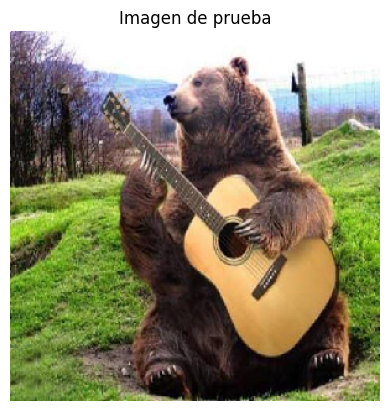

In [9]:
images = preprocesar_imagenes([path_to_image])
plt.figure()
plt.title("Imagen de prueba")
plt.imshow(images[0] / 2 + 0.5) # rango entre [0,1]
                                # para visualiación

plt.axis('off')
plt.show()

## Predicción en la imagen de prueba

InceptionV3 predice 1000 clases, y cada clase tiene su etiqueta:

* 0	tench, Tinca tinca (pez de agua dulce)
* 1	goldfish, Carassius auratus (pez dorado)
* 2	great white shark, white shark, man-eater, man-eating shark, Carcharodon caharias',
* 3	tiger shark, Galeocerdo cuvieri

...

* 997	bolete (tipo de hongo)
* 998	ear, spike, capitulum
* 999	toilet tissue, toilet paper, bathroom tissue

In [10]:
start = time.time()
y_pred = model.predict(images)
end = time.time()
print(f"Tiempo de predicción: {end - start:.2f} segundos")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Tiempo de predicción: 11.21 segundos


In [12]:
start = time.time()
for x in decode_predictions(y_pred, top=10)[0]:
    print(f"Clase: {x[1]:<12} - Probabilidad: {x[2]:.5f}")
    if x[2]>0.01:
      print("here")
end = time.time()
print(f"Tiempo de predicción: {end - start:.2f} segundos")


Clase: brown_bear   - Probabilidad: 0.58364
here
Clase: acoustic_guitar - Probabilidad: 0.04490
here
Clase: electric_guitar - Probabilidad: 0.01026
here
Clase: sloth_bear   - Probabilidad: 0.00687
Clase: ice_bear     - Probabilidad: 0.00521
Clase: three-toed_sloth - Probabilidad: 0.00488
Clase: banjo        - Probabilidad: 0.00389
Clase: Arabian_camel - Probabilidad: 0.00338
Clase: American_black_bear - Probabilidad: 0.00319
Clase: Sussex_spaniel - Probabilidad: 0.00245
Tiempo de predicción: 0.01 segundos


## LimeImageExplainer

En la siguiente [documentación](https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=submodular_pick#module-lime.lime_image) se detallan las clases y métodos utilizados a continuación.


In [13]:
explainer = lime_image.LimeImageExplainer()

In [15]:
start = time.time()
explanation = explainer.explain_instance(
    images[0], #imagen a explicar
    model, #modelo a explicar
    top_labels=10, # explicaciones para las top_labels etiquetas con mayores probabilidades de predicción
    num_samples=2000, #tamaño del vecindario para obtener modelo lineal.
)
end = time.time()
print(f"Tiempo de predicción: {end - start:.2f} segundos")

  0%|          | 0/2000 [00:00<?, ?it/s]

Tiempo de predicción: 85.83 segundos


### Superpixeles generados

In [16]:
explanation.segments.max()

74

In [17]:
explanation.segments

array([[12, 12, 12, ...,  6,  6,  6],
       [12, 12, 12, ...,  6,  6,  6],
       [12, 12, 12, ...,  6,  6,  6],
       ...,
       [71, 71, 71, ..., 73, 73, 73],
       [71, 71, 71, ..., 73, 73, 73],
       [71, 71, 71, ..., 73, 73, 73]])

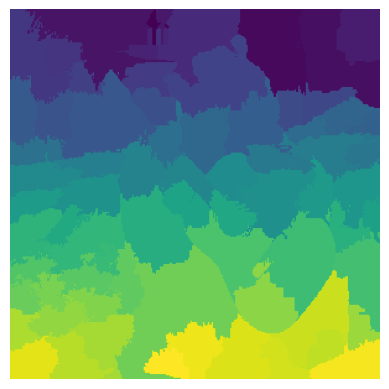

In [18]:
plt.imshow(explanation.segments)
plt.axis('off')
plt.show()

### Superpixeles que contribuyen positivamente a la predicción de la clase indicada


In [22]:

explanation.top_labels

[294, 402, 546, 297, 296, 364, 420, 354, 295, 220]

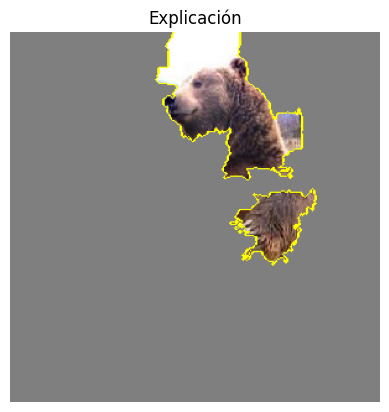

In [28]:
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0], #etiqueta a explicar
    positive_only=True, # toma los superpíxeles que contribuyan positivamente a la predicción de la etiqueta.
    num_features=5, # núm. de superpíxeles a incluir en la explicación
    hide_rest=True,
)

plt.figure()
plt.title("Explicación")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()

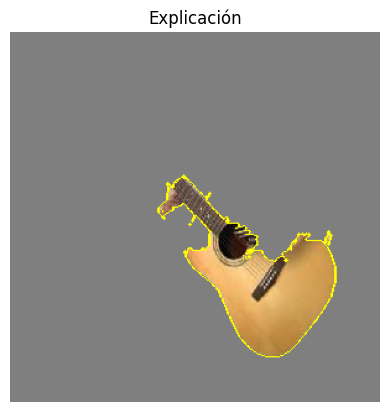

In [29]:
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1], #etiqueta a explicar
    positive_only=True, # toma los superpíxeles que contribuyan positivamente a la predicción de la etiqueta.
    num_features=5, # núm. de superpíxeles a incluir en la explicación
    hide_rest=True,
)

plt.figure()
plt.title("Explicación")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()

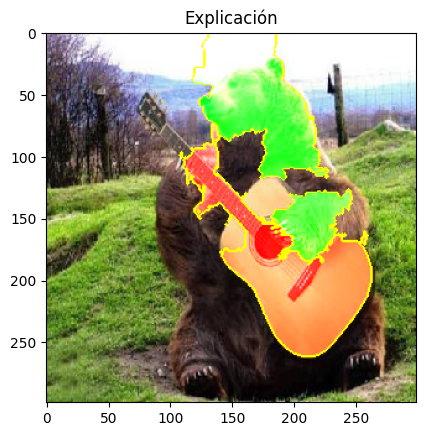

In [27]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False,
)
plt.figure()
plt.title("Explicación")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

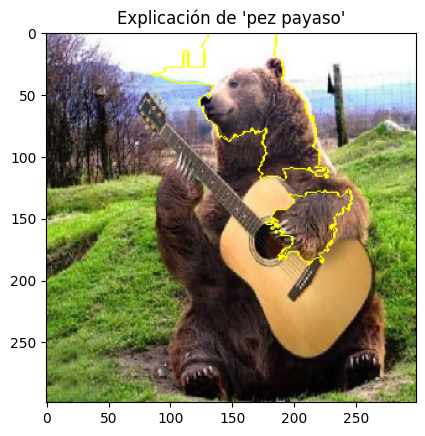

In [ ]:
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure()
plt.title("Explicación de 'pez payaso'")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

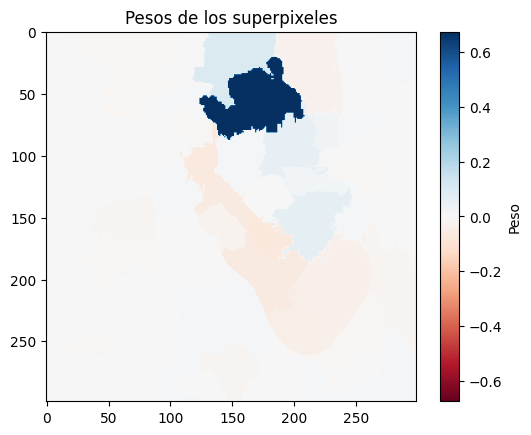

In [30]:
# Seleccionar el índice de la clase más probable
top_class_index = explanation.top_labels[0]

# Extraer los pesos asociados a cada superpixel de la explicación
class_weights = explanation.local_exp[top_class_index]

# Crear un diccionario que mapea los superpixeles a sus pesos
superpixel_weights = dict(class_weights)

# Mapear los pesos a los superpixeles para generar un mapa de calor
heatmap = np.vectorize(superpixel_weights.get)(explanation.segments)

plt.figure()
plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar(label='Peso')
plt.title('Pesos de los superpixeles')
plt.show()